<a href="https://colab.research.google.com/github/allnes/pcam_train/blob/master/pcam_fcn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%pip install keras-metrics

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
cd  '/content/drive/My Drive/DL_PCAM'

/content/drive/My Drive/DL_PCAM


In [3]:
%ls

camelyonpatch_level_2_split_test_meta.csv
camelyonpatch_level_2_split_test_x.h5
camelyonpatch_level_2_split_test_x.h5.gz
camelyonpatch_level_2_split_test_y.h5
camelyonpatch_level_2_split_test_y.h5.gz
camelyonpatch_level_2_split_train_meta.csv
camelyonpatch_level_2_split_train_x.h5
camelyonpatch_level_2_split_train_x.h5.gz
camelyonpatch_level_2_split_train_y.h5
camelyonpatch_level_2_split_train_y.h5.gz
camelyonpatch_level_2_split_valid_meta.csv
camelyonpatch_level_2_split_valid_x.h5
camelyonpatch_level_2_split_valid_x.h5.gz
camelyonpatch_level_2_split_valid_y.h5
camelyonpatch_level_2_split_valid_y.h5.gz
model.png
__pycache__/


In [0]:
import gzip
import shutil
def uzip_file(file_name, origin_name):
  with gzip.open(file_name, 'rb') as f_in:
      with open(origin_name, 'wb') as f_out:
          shutil.copyfileobj(f_in, f_out)


In [0]:
train_x_name = 'camelyonpatch_level_2_split_train_x.h5'
train_y_name = 'camelyonpatch_level_2_split_train_y.h5'

test_x_name = 'camelyonpatch_level_2_split_test_x.h5'
test_y_name = 'camelyonpatch_level_2_split_test_y.h5'

valid_x_name = 'camelyonpatch_level_2_split_valid_x.h5'
valid_y_name = 'camelyonpatch_level_2_split_valid_y.h5'

meta_train_name = 'camelyonpatch_level_2_split_train_meta.csv'
meta_valid_name = 'camelyonpatch_level_2_split_valid_meta.csv'
meta_test_name  = 'camelyonpatch_level_2_split_test_meta.csv'

# uzip_file(train_x_name + '.gz', train_x_name)
# uzip_file(train_y_name + '.gz', train_y_name)

# uzip_file(test_x_name + '.gz', test_x_name)
# uzip_file(test_y_name + '.gz', test_y_name)

# uzip_file(valid_x_name + '.gz', valid_x_name)
# uzip_file(valid_y_name + '.gz', valid_y_name)


In [6]:
from keras.utils import HDF5Matrix, normalize
import pandas as pd

x_train = HDF5Matrix(train_x_name, 'x')
y_train = HDF5Matrix(train_y_name, 'y')

x_valid = HDF5Matrix(valid_x_name, 'x')
y_valid = HDF5Matrix(valid_y_name, 'y')

x_test = HDF5Matrix(test_x_name, 'x')
y_test = HDF5Matrix(test_y_name, 'y')

meta_train = pd.read_csv(meta_train_name)
meta_valid = pd.read_csv(meta_valid_name)
meta_test  = pd.read_csv(meta_test_name)

Using TensorFlow backend.


262144
<class 'keras.utils.io_utils.HDF5Matrix'>
<class 'numpy.ndarray'>
(96, 96, 3)


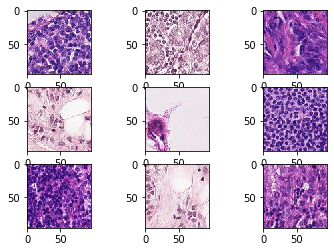

In [7]:
print(len(x_train))
print(type(x_train))
print(type(x_train[0]))
print(x_train[0].shape)
from matplotlib import pyplot
for i in range(0, 9):
	pyplot.subplot(330 + 1 + i)
	pyplot.imshow(x_train[i], cmap=pyplot.get_cmap('gray'))
pyplot.show()


In [0]:
current_core = 32
full_size = current_core * current_core * 3
original_shape = (96, 96, 3)
new_shape = (current_core, current_core, 3)
new_size = (current_core, current_core)

In [0]:
import cv2 as cv
import numpy as np
def resize_for_train(x_array, x_shape):
  return np.array([cv.resize(elem, dsize=x_shape) for elem in x_array])
x_train = resize_for_train(x_train, new_size)
x_valid = resize_for_train(x_valid, new_size)
x_test  = resize_for_train(x_test,  new_size)


In [0]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Reshape, Lambda, Input, Dropout
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
import keras_metrics as ksm
import tensorflow as tf
import matplotlib.pyplot as plt

def plot_metrics(code_metrics, name_metrics):
    plt.plot(history.history[code_metrics])
    plt.plot(history.history['val_' + code_metrics])
    plt.title('Model ' + name_metrics)
    plt.ylabel(name_metrics)
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

def show_metrics(list_metrics, name_stage, name_model):
    name_metrics = ['accuracy', 'precision', 'recall', 'f1-score']
    for i in range(4):
        print(name_model + ' ' + name_stage + ' ' + 
              name_metrics[i] + ' : ' + str(list_metrics[i + 1] * 100))




Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 1, 1, 3072)        0         
_________________________________________________________________
dense_1 (Dense)              (None, 1, 1, 3072)        9440256   
_________________________________________________________________
activation_1 (Activation)    (None, 1, 1, 3072)        0         
_________________________________________________________________
dense_2 (Dense)              (None, 1, 1, 3072)        9440256   
_________________________________________________________________
activation_2 (Activation)    (None, 1, 1, 3072)        0         
_________________________________________________________________
dense_3 (Dense)              (None, 1, 1, 3072)        9440256   
_________________________________________________________________
activation_3 (Activation)    (None, 1, 1, 3072)    

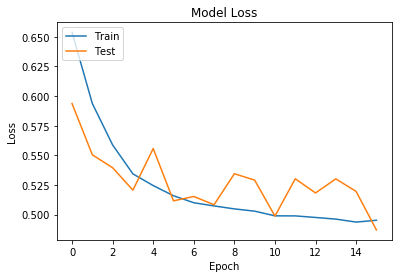

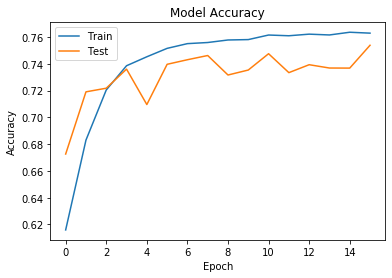

262144/262144 [==============================] - 25s 97us/step
FCN with the same layers train accuracy : 76.20620727539062
FCN with the same layers train precision : 77.6990194180394
FCN with the same layers train recall : 73.51150512689703
FCN with the same layers train f1-score : 75.5472742887059
32768/32768 [==============================] - 3s 95us/step
FCN with the same layers valid accuracy : 75.103759765625
FCN with the same layers valid precision : 78.7681311745584
FCN with the same layers valid recall : 68.67249068318974
FCN with the same layers valid f1-score : 73.37466865220668
32768/32768 [==============================] - 3s 95us/step
FCN with the same layers test accuracy : 72.94921875
FCN with the same layers test precision : 76.95730175761064
FCN with the same layers test recall : 65.48207852436049
FCN with the same layers test f1-score : 70.75745082507004


In [11]:
name_model = 'FCN with the same layers'
model = Sequential([
    # ---------------------------------------------------------#
    Reshape((1, 1, full_size,), input_shape=new_shape),
    # ---------------------------------------------------------#
    Dense(int(full_size), 
          kernel_initializer='random_uniform', 
          bias_initializer='random_uniform'), 
    Activation('relu'),
    # ---------------------------------------------------------#
    Dense(int(full_size), 
          kernel_initializer='random_uniform', 
          bias_initializer='random_uniform'), 
    Activation('relu'),
    # ---------------------------------------------------------#
    Dense(int(full_size), 
          kernel_initializer='random_uniform', 
          bias_initializer='random_uniform'), 
    Activation('relu'),
    # ---------------------------------------------------------#
    Dense(int(full_size / 2), 
          kernel_initializer='random_uniform', 
          bias_initializer='random_uniform'), 
    Activation('relu'),
    # ---------------------------------------------------------#
    Dense(int(full_size / 4), 
          kernel_initializer='random_uniform', 
          bias_initializer='random_uniform'), 
    Activation('relu'),
    # ---------------------------------------------------------#
    Dense(int(full_size / 8), 
          kernel_initializer='random_uniform', 
          bias_initializer='random_uniform'), 
    Activation('relu'),
    # ---------------------------------------------------------#
    Dense(1),                    
    Activation('sigmoid'),
    # ---------------------------------------------------------#
])

model.summary()
model.compile(loss='binary_crossentropy', optimizer='sgd', 
              metrics = ['binary_accuracy', 
                         ksm.binary_precision(), 
                         ksm.binary_recall(),
                         ksm.binary_f1_score()])

batch_size = 2048

datagen = ImageDataGenerator(
              preprocessing_function=lambda x: x/255.,
              width_shift_range=2,   # randomly shift images horizontally
              height_shift_range=2,  # randomly shift images vertically 
              horizontal_flip=True,  # randomly flip images
              vertical_flip=True)    # randomly flip images

history = model.fit_generator(
    datagen.flow(x_train, y_train, batch_size=batch_size),
    steps_per_epoch=len(x_train) // batch_size,
    epochs=16, 
    shuffle='batch', 
    use_multiprocessing=True,
    validation_data=datagen.flow(x_valid, y_valid, batch_size=batch_size))

plot_metrics('loss', 'Loss')
plot_metrics('binary_accuracy',  'Accuracy')

show_metrics(model.evaluate(x_train, y_train), 'train', name_model)
show_metrics(model.evaluate(x_valid, y_valid), 'valid', name_model)
show_metrics(model.evaluate(x_test,  y_test),  'test',  name_model)


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_2 (Reshape)          (None, 1, 1, 3072)        0         
_________________________________________________________________
dense_8 (Dense)              (None, 1, 1, 1536)        4720128   
_________________________________________________________________
activation_8 (Activation)    (None, 1, 1, 1536)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 1, 1536)        0         
_________________________________________________________________
dense_9 (Dense)              (None, 1, 1, 1024)        1573888   
_________________________________________________________________
activation_9 (Activation)    (None, 1, 1, 1024)        0         
____

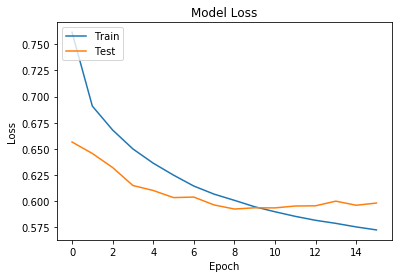

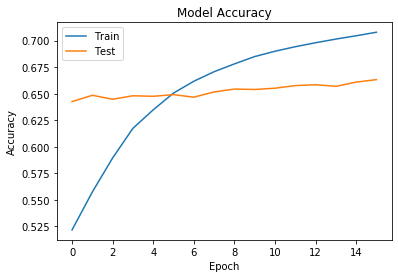

262144/262144 [==============================] - 24s 90us/step
FCN with dropout train accuracy : 68.51768493652344
FCN with dropout train precision : 62.914012992991154
FCN with dropout train recall : 90.2137756346968
FCN with dropout train f1-score : 74.13037610797134
32768/32768 [==============================] - 3s 89us/step
FCN with dropout valid accuracy : 68.2586669921875
FCN with dropout valid precision : 63.35242527267159
FCN with dropout valid recall : 86.51006711356614
FCN with dropout valid f1-score : 73.1358269240132
32768/32768 [==============================] - 3s 89us/step
FCN with dropout test accuracy : 67.2637939453125
FCN with dropout test precision : 62.96228319692134
FCN with dropout test recall : 83.7882396038115
FCN with dropout test f1-score : 71.89750891971325


In [12]:
name_model = 'FCN with dropout'
model = Sequential([
    # ---------------------------------------------------------#
    Reshape((1, 1, full_size,), input_shape=new_shape),
    # ---------------------------------------------------------#
    Dense(int(full_size / 2), 
          kernel_initializer='random_uniform', 
          bias_initializer='random_uniform'), 
    Activation('relu'),
    Dropout(0.5),
    # ---------------------------------------------------------#
    Dense(int(full_size / 3), 
          kernel_initializer='random_uniform', 
          bias_initializer='random_uniform'), 
    Activation('relu'),
    Dropout(0.5),
    # ---------------------------------------------------------#
    Dense(int(full_size / 4), 
          kernel_initializer='random_uniform', 
          bias_initializer='random_uniform'), 
    Activation('relu'),
    Dropout(0.5),
    # ---------------------------------------------------------#
    Dense(1),                    
    Activation('sigmoid'),
    # ---------------------------------------------------------#
])

model.summary()
model.compile(loss='binary_crossentropy', optimizer='sgd', 
              metrics = ['binary_accuracy', 
                         ksm.binary_precision(), 
                         ksm.binary_recall(),
                         ksm.binary_f1_score()])

batch_size = 2048

datagen = ImageDataGenerator(
              preprocessing_function=lambda x: x/255.,
              width_shift_range=2,   # randomly shift images horizontally
              height_shift_range=2,  # randomly shift images vertically 
              horizontal_flip=True,  # randomly flip images
              vertical_flip=True)    # randomly flip images

history = model.fit_generator(
    datagen.flow(x_train, y_train, batch_size=batch_size),
    steps_per_epoch=len(x_train) // batch_size,
    epochs=16, 
    shuffle='batch', 
    use_multiprocessing=True,
    validation_data=datagen.flow(x_valid, y_valid, batch_size=batch_size))

plot_metrics('loss', 'Loss')
plot_metrics('binary_accuracy',  'Accuracy')

show_metrics(model.evaluate(x_train, y_train), 'train', name_model)
show_metrics(model.evaluate(x_valid, y_valid), 'valid', name_model)
show_metrics(model.evaluate(x_test,  y_test),  'test',  name_model)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_3 (Reshape)          (None, 1, 1, 3072)        0         
_________________________________________________________________
dense_12 (Dense)             (None, 1, 1, 1536)        4720128   
_________________________________________________________________
activation_12 (Activation)   (None, 1, 1, 1536)        0         
_________________________________________________________________
dense_13 (Dense)             (None, 1, 1, 1024)        1573888   
_________________________________________________________________
activation_13 (Activation)   (None, 1, 1, 1024)        0         
_________________________________________________________________
dense_14 (Dense)             (None, 1, 1, 768)         787200    
_________________________________________________________________
activation_14 (Activation)   (None, 1, 1, 768)        

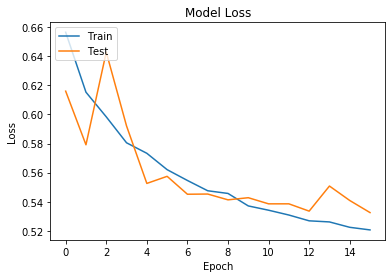

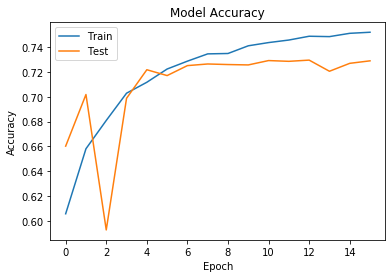

262144/262144 [==============================] - 23s 89us/step
FCN without dropout train accuracy : 75.40931701660156
FCN without dropout train precision : 77.14413790286714
FCN without dropout train recall : 72.2137451171324
FCN without dropout train f1-score : 74.59755891243861
32768/32768 [==============================] - 3s 87us/step
FCN without dropout valid accuracy : 73.1414794921875
FCN without dropout valid precision : 77.50799651005009
FCN without dropout valid recall : 65.13531675688718
FCN without dropout valid f1-score : 70.78505727781221
32768/32768 [==============================] - 3s 86us/step
FCN without dropout test accuracy : 70.6939697265625
FCN without dropout test precision : 75.0926063114899
FCN without dropout test recall : 61.891677352006525
FCN without dropout test f1-score : 67.85606199158694


In [13]:
name_model = 'FCN without dropout'
model = Sequential([
    # ---------------------------------------------------------#
    Reshape((1, 1, full_size,), input_shape=new_shape),
    # ---------------------------------------------------------#
    Dense(int(full_size / 2), 
          kernel_initializer='random_uniform', 
          bias_initializer='random_uniform'), 
    Activation('relu'),
    # ---------------------------------------------------------#
    Dense(int(full_size / 3), 
          kernel_initializer='random_uniform', 
          bias_initializer='random_uniform'), 
    Activation('relu'),
    # ---------------------------------------------------------#
    Dense(int(full_size / 4), 
          kernel_initializer='random_uniform', 
          bias_initializer='random_uniform'), 
    Activation('relu'),
    # ---------------------------------------------------------#
    Dense(1),                    
    Activation('sigmoid'),
    # ---------------------------------------------------------#
])

model.summary()
model.compile(loss='binary_crossentropy', optimizer='sgd', 
              metrics = ['binary_accuracy', 
                         ksm.binary_precision(), 
                         ksm.binary_recall(),
                         ksm.binary_f1_score()])

batch_size = 2048

datagen = ImageDataGenerator(
              preprocessing_function=lambda x: x/255.,
              width_shift_range=2,   # randomly shift images horizontally
              height_shift_range=2,  # randomly shift images vertically 
              horizontal_flip=True,  # randomly flip images
              vertical_flip=True)    # randomly flip images

history = model.fit_generator(
    datagen.flow(x_train, y_train, batch_size=batch_size),
    steps_per_epoch=len(x_train) // batch_size,
    epochs=16, 
    shuffle='batch', 
    use_multiprocessing=True,
    validation_data=datagen.flow(x_valid, y_valid, batch_size=batch_size))

plot_metrics('loss', 'Loss')
plot_metrics('binary_accuracy',  'Accuracy')

show_metrics(model.evaluate(x_train, y_train), 'train', name_model)
show_metrics(model.evaluate(x_valid, y_valid), 'valid', name_model)
show_metrics(model.evaluate(x_test,  y_test),  'test',  name_model)